# Getting Started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

2023-10-26 17:49:08.625245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.display import Audio, display

def play_sound():
    display(Audio(url="https://www.soundjay.com/button/beep-07.wav", autoplay=True))

# At the end of your code cell
play_sound()

In [3]:
snp = pd.read_csv("../data/s&pv1.csv")
rus = pd.read_csv("../data/russell500.csv")

## Data Cleaning

In [4]:
snp.shape,rus.shape

((501, 48), (507, 36))

In [5]:
drop_cols = ['Market Cap Category', 'Yearly_NetIncome', 'Profitable',
       'Avg_Volume_1_6', 'Volume_Category', 'Avg Monthly Volume',
       'Avg Quarterly Income', 'Volume to Income Ratio', 'Avg Monthly Income',
       'Market Cap to Avg Monthly Income Ratio']
snp.drop(columns=drop_cols,inplace=True)

In [6]:
snp.shape,rus.shape

((501, 38), (507, 36))

In [7]:
rus['in_index'] = 0
rus['Underaged'] = np.where(rus['Q4_NetIncome'].isna(), 1, 0)
rus['Underaged'].value_counts()

0    505
1      2
Name: Underaged, dtype: int64

In [8]:
shared_tickers = snp[snp['Ticker'].isin(rus['Ticker'].unique())]['Ticker'].unique()
rus = rus[~rus['Ticker'].isin(shared_tickers)]

In [9]:
rus.isnull().sum()

Ticker                 0
Market Cap             0
Exchange               0
Outstanding Shares     0
Q1_NetIncome           0
Q2_NetIncome           0
Q3_NetIncome           0
Q4_NetIncome           2
Q5_NetIncome           2
Q6_NetIncome           2
Q7_NetIncome           3
Q8_NetIncome           4
Month1_Volume          1
Month2_Volume          1
Month3_Volume          4
Month4_Volume          5
Month5_Volume          7
Month6_Volume          7
Month7_Volume          7
Month8_Volume          8
Month9_Volume          8
Month10_Volume         8
Month11_Volume         8
Month12_Volume         9
Month13_Volume         9
Month14_Volume         9
Month15_Volume         9
Month16_Volume         9
Month17_Volume         9
Month18_Volume         9
Month19_Volume         9
Month20_Volume        10
Month21_Volume        10
Month22_Volume        11
Month23_Volume        13
Month24_Volume        14
in_index               0
Underaged              0
dtype: int64

In [10]:
rus.loc[rus['Ticker'] == 'CAVA', 'Market Cap'] = 3750000000
rus.loc[rus['Ticker'] == 'CAVA', 'Outstanding Shares'] = 113580000
rus.loc[rus['Ticker'] == 'LLYVA', 'Market Cap'] = 26430000000
rus.loc[rus['Ticker'] == 'LLYVA', 'Oustanding Shares'] = 25560000
rus.loc[rus['Ticker'] == 'LLYVK', 'Market Cap'] = 26430000000
rus.loc[rus['Ticker'] == 'LLYVK', 'Outstanding Shares'] = 26430000000
rus.loc[rus['Ticker'] == 'PHIN', 'Market Cap'] = 1240000000
rus.loc[rus['Ticker'] == 'PHIN', 'Outstanding Shares'] = 46600000

In [11]:
rus['Market Cap'] = rus['Market Cap'].astype(int)

In [12]:
rus.dtypes,snp.dtypes

(Ticker                 object
 Market Cap              int64
 Exchange               object
 Outstanding Shares      int64
 Q1_NetIncome            int64
 Q2_NetIncome            int64
 Q3_NetIncome            int64
 Q4_NetIncome          float64
 Q5_NetIncome          float64
 Q6_NetIncome          float64
 Q7_NetIncome          float64
 Q8_NetIncome          float64
 Month1_Volume         float64
 Month2_Volume         float64
 Month3_Volume         float64
 Month4_Volume         float64
 Month5_Volume         float64
 Month6_Volume         float64
 Month7_Volume         float64
 Month8_Volume         float64
 Month9_Volume         float64
 Month10_Volume        float64
 Month11_Volume        float64
 Month12_Volume        float64
 Month13_Volume        float64
 Month14_Volume        float64
 Month15_Volume        float64
 Month16_Volume        float64
 Month17_Volume        float64
 Month18_Volume        float64
 Month19_Volume        float64
 Month20_Volume        float64
 Month21

In [13]:
rus['in_index'].value_counts(),snp['in_index'].value_counts()

(0    507
 Name: in_index, dtype: int64,
 1    501
 Name: in_index, dtype: int64)

# Model 1: Classification Model of SP500 Index Components
---

## Classification Model Prep (1st Run Through)


In [14]:
np.random.seed(42)

In [15]:
market = pd.concat([snp, rus], ignore_index=True)
market = market.sample(frac=1).reset_index(drop=True)

market.to_csv("total_market.csv",index=False)

X = market.drop(columns=['in_index'])
y = market['in_index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
# Saving Ticker for later identification
tickers_train = X_train['Ticker'].copy()
tickers_test = X_test['Ticker'].copy()

# Dropping Ticker and Exchange
X_train = X_train.drop(columns=['Ticker', 'Exchange'])
X_test = X_test.drop(columns=['Ticker', 'Exchange'])

## Classification

#### We are going to train our model first if its able to correctly and highly accurately predict which tickers are indeed in fact in the S&P and which are not. Once we have a solid model that can distiniguish between the two indexes then we can move on to predicting quaretely income and volume

### Logistic Regression (V1)

In [22]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handling missing values
    ('scaler', StandardScaler()),  # Scaling data
    ('classifier', LogisticRegression())  # Logistic Regression
])

# Step 3: Model Training and Testing
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.7777777777777778
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       164
           1       0.91      0.63      0.74       169

    accuracy                           0.78       333
   macro avg       0.81      0.78      0.77       333
weighted avg       0.81      0.78      0.77       333



### Logistic Regression (V2)

In [63]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [64]:
%timeit
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['saga', 'liblinear'],  # Only these solvers support l1
        'class_weight': [None, 'balanced'],
        'C': np.logspace(-4, 4, 10)
    },
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'sag', 'saga', 'newton-cg', 'liblinear'],
        'class_weight': [None, 'balanced'],
        'C': np.logspace(-4, 4, 10)
    }
]

grid = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42),
                    param_grid, cv=5, scoring='f1', n_jobs=-1)

grid.fit(X_train, y_train)

# Retrieve the best estimator
clf_best = grid.best_estimator_

# 3. Model Evaluation
# -------------------

# Predict on test set
y_pred = clf_best.predict(X_test)
y_pred_proba = clf_best.predict_proba(X_test)[:,1]

# Print performance metrics
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
play_sound()

ROC AUC Score: 0.8958724202626641
Log Loss: 0.4308661215597974
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       164
           1       0.88      0.72      0.79       169

    accuracy                           0.80       333
   macro avg       0.82      0.81      0.80       333
weighted avg       0.82      0.80      0.80       333

Confusion Matrix:
 [[147  17]
 [ 48 121]]


### Random Forest Classifier (v1)

In [65]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [66]:
y_pred = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:, 1]

In [67]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Log Loss
logloss = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {logloss}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ROC AUC Score: 0.9485315341319095
Log Loss: 0.3130763634691878
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       164
           1       0.94      0.82      0.87       169

    accuracy                           0.88       333
   macro avg       0.89      0.88      0.88       333
weighted avg       0.89      0.88      0.88       333

Confusion Matrix:
[[155   9]
 [ 31 138]]


### Random Forest Classifier (v2)

In [68]:
%timeit

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [ 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Getting the best estimator/model
best_rf = grid_search.best_estimator_

# Making predictions on the test set using the best model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:,1]

# Evaluating the best model
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
ROC AUC Score: 0.9487299754654351
Log Loss: 0.31352327983513845
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       164
           1       0.93      0.82      0.87       169

    accuracy                           0.88       333
   macro avg       0.88      0.88      0.88       333
weighted avg       0.89      0.88      0.88       333

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.8717655770654819


From working on Random Forest Classifier and modifying the parameters several times we learned a few things:
* The performance metrics seems to be sensitive to small changes
* With Overfitting, the more estimater the slightly better but it is making the model much more complex
* When there is a higher min sample split we see the need for less estimators when it comes to best estimator


We are going to try new methods of hyperparameter tune the grid serach instead this time in the next version of Random Forest Classifier. Also we are going to add max featues to see if that does make a difference as well which I doubt it does.

### Random Forest Classifier (v3)

In [69]:
param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [ 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2', None]  # Added max_features
}

rf = RandomForestClassifier(random_state=42)

# Here we're going to use both KFold and StratifiedKFold for demonstration, you can choose one based on your data.
cv_methods = [KFold(n_splits=5, shuffle=True, random_state=42), 
              StratifiedKFold(n_splits=5, shuffle=True, random_state=42)]

best_scores = {}
best_params = {}

for cv_method in cv_methods:
    grid_search = GridSearchCV(rf, param_grid, cv=cv_method, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Predict on test set
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Save results for current cv_method
    method_name = str(cv_method).split("(")[0]  # Extracting the name of the CV method for display purposes
    best_scores[method_name] = roc_auc_score(y_test, y_pred_proba)
    best_params[method_name] = grid_search.best_params_

    # Print out metrics
    print(f"Cross-Validation Method: {method_name}")
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Log Loss:", log_loss(y_test, y_pred_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Best Parameters:", grid_search.best_params_)
    print("==============================================\n")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Cross-Validation Method: KFold
ROC AUC Score: 0.9509308702554481
Log Loss: 0.3112478558125301
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       164
           1       0.93      0.83      0.88       169

    accuracy                           0.89       333
   macro avg       0.89      0.89      0.89       333
weighted avg       0.89      0.89      0.89       333

Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Cross-Validation Method: StratifiedKFold
ROC AUC Score: 0.9464930004329629
Log Loss: 0.3226993670150462
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       164
           1       0.94      0.82      0.88       169

    acc

Observations from the 2 Folding Types:
* Both models have very close precision values with stratefied giving slightly better results
* with ROC AUC Stratified also has slightly better results
* Best hyperparameters are actually very different amongst the two suggesting the fold here will play the biggest role but nonetheless we need a better model

### Gradient Boosted Tree (v1)

In [70]:
param_grid = {
    'learning_rate': [ 0.05, 0.1,0.2],
    'n_estimators': [25, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

xgbc = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)

grid_search = GridSearchCV(xgbc, param_grid, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predictions
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluations
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/zubeirsaid/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/zubeirsaid/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


ROC AUC Score: 0.9579304372925386
Log Loss: 0.2763725772734966
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       164
           1       0.92      0.85      0.88       169

    accuracy                           0.89       333
   macro avg       0.89      0.89      0.89       333
weighted avg       0.89      0.89      0.89       333

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


##### Since this is our best peforming model and Im not sure whats better than XGB, I will do a feature analysis and try to work on improving this model. Ideally I need either precision or recall to be above 0.95

### Gradient Boosted Tree Feature Analysis

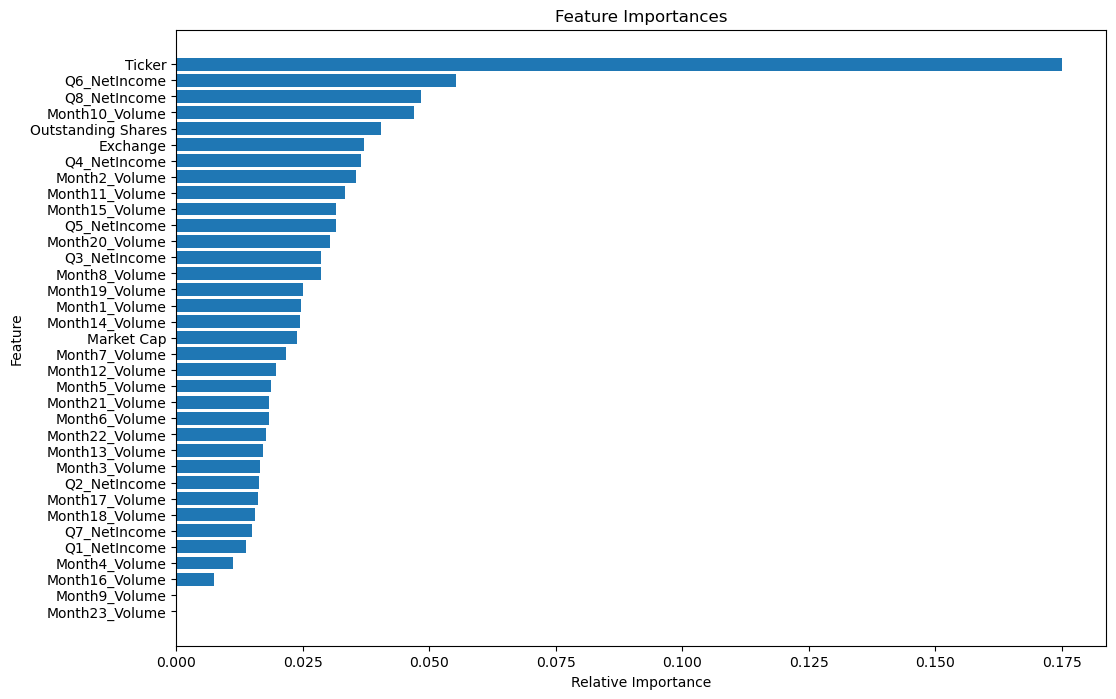

In [71]:
# Using the best parameters obtained from the GridSearch
model = xgb.XGBClassifier(
    objective='binary:logistic',
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=0.8
)

model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Match importances with feature names
features = list(X.columns)
importances_with_names = sorted(list(zip(features, feature_importances)), key=lambda x: x[1], reverse=True)

# Visualization
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.barh([x[0] for x in importances_with_names], [x[1] for x in importances_with_names])
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [72]:
print("Feature Importance Analysis:\n")
for feature, importance in importances_with_names:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature Importance Analysis:

Feature: Ticker, Importance: 0.1750
Feature: Q6_NetIncome, Importance: 0.0553
Feature: Q8_NetIncome, Importance: 0.0484
Feature: Month10_Volume, Importance: 0.0469
Feature: Outstanding Shares, Importance: 0.0404
Feature: Exchange, Importance: 0.0371
Feature: Q4_NetIncome, Importance: 0.0364
Feature: Month2_Volume, Importance: 0.0355
Feature: Month11_Volume, Importance: 0.0334
Feature: Month15_Volume, Importance: 0.0316
Feature: Q5_NetIncome, Importance: 0.0315
Feature: Month20_Volume, Importance: 0.0304
Feature: Q3_NetIncome, Importance: 0.0286
Feature: Month8_Volume, Importance: 0.0285
Feature: Month19_Volume, Importance: 0.0250
Feature: Month1_Volume, Importance: 0.0246
Feature: Month14_Volume, Importance: 0.0244
Feature: Market Cap, Importance: 0.0238
Feature: Month7_Volume, Importance: 0.0217
Feature: Month12_Volume, Importance: 0.0196
Feature: Month5_Volume, Importance: 0.0186
Feature: Month21_Volume, Importance: 0.0184
Feature: Month6_Volume, Importa

The biggest takeaway here is that:
1. Ticker has wayyyyyyyy too big of a significance and needs to be dropped from the training set in fear of overfiting
2. Market Cap should indefinitely be the single most important feature and the fact that its that low is concerning

What I would like to do is run through all the above models with ticker dropped and think of some models that I could use where I can adjust the weighting of Market Cap but first one more GBT run

### Gradient Boosted Tree (v2)

In [81]:
# Ensure you've defined your train/test split and the XGBClassifier
from xgboost import XGBClassifier

# Given the best parameters from before:
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8,
    'objective': 'binary:logistic'
}

xgbc = XGBClassifier(**best_params)
xgbc.fit(X_train, y_train)

# Now calibrate using CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgbc = CalibratedClassifierCV(xgbc, method='sigmoid', cv='prefit')
calibrated_xgbc.fit(X_train, y_train)
probs = calibrated_xgbc.predict_proba(X_test)

In [74]:
y_prob_calibrated = calibrated_xgbc.predict_proba(X_test)[:, 1]

# Convert probabilities to class predictions (threshold = 0.5)
y_pred_calibrated = (y_prob_calibrated > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_calibrated))

# Print the ROC AUC Score and Log Loss
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_calibrated))
print("Log Loss:", log_loss(y_test, y_prob_calibrated))


              precision    recall  f1-score   support

           0       0.86      0.91      0.88       164
           1       0.91      0.85      0.88       169

    accuracy                           0.88       333
   macro avg       0.88      0.88      0.88       333
weighted avg       0.88      0.88      0.88       333

ROC AUC Score: 0.9592293260210707
Log Loss: 0.31587142265355816


### Market Cap Correlation

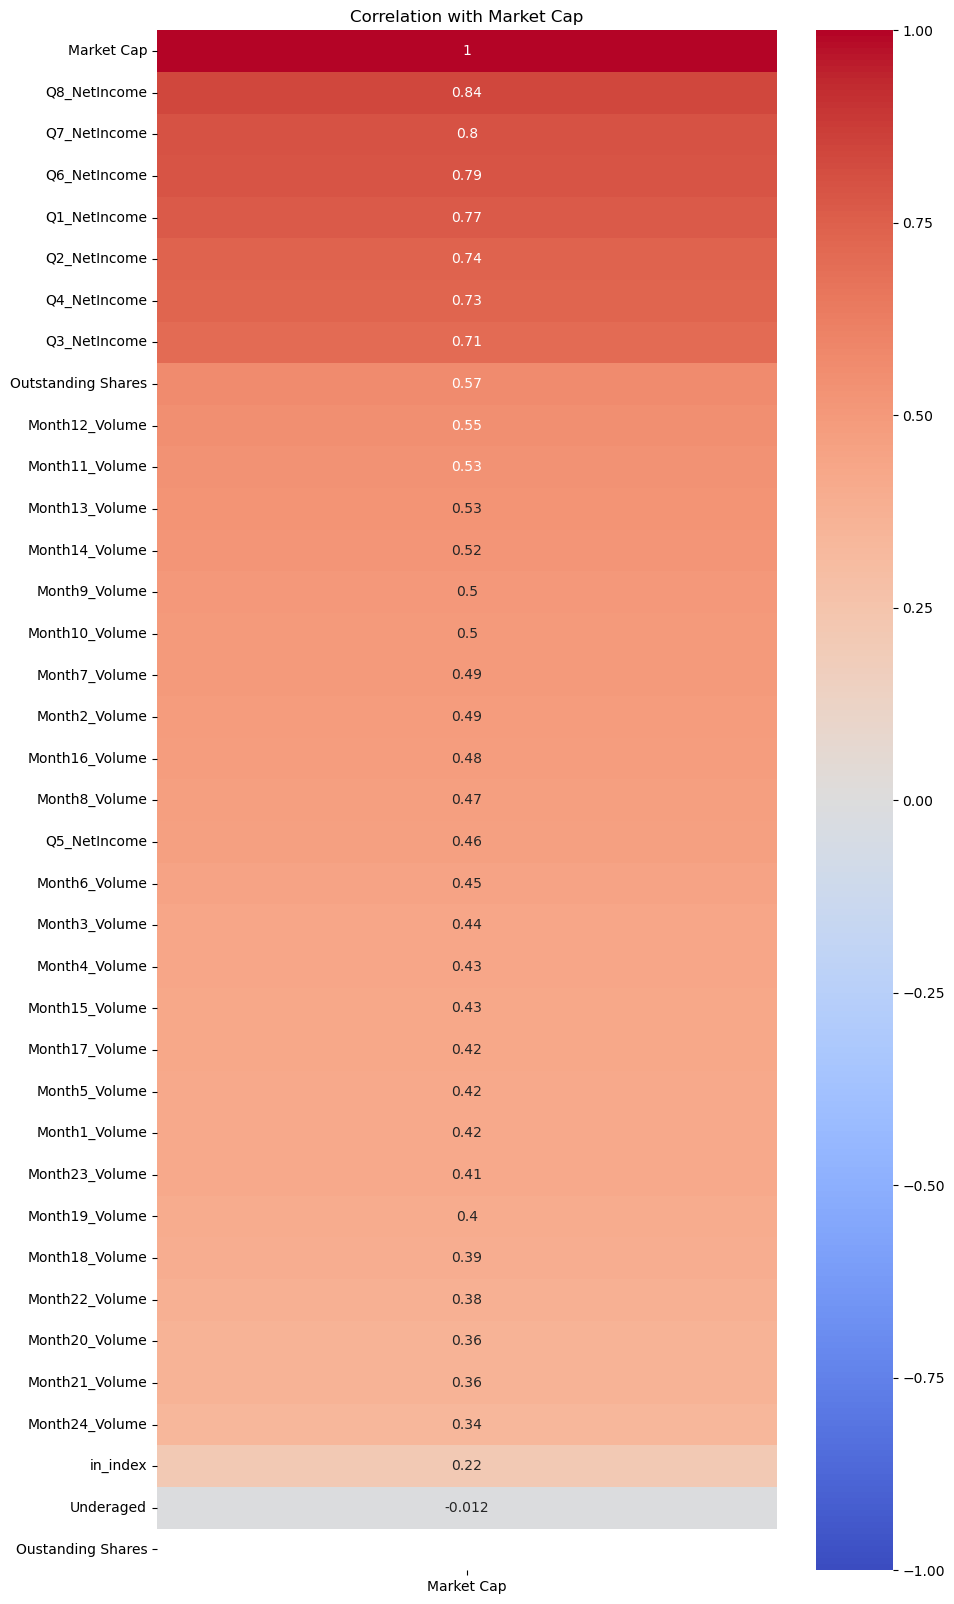

Market Cap            1.000000
Q8_NetIncome          0.837111
Q7_NetIncome          0.803476
Q6_NetIncome          0.792403
Q1_NetIncome          0.766625
Q2_NetIncome          0.739211
Q4_NetIncome          0.728487
Q3_NetIncome          0.707982
Outstanding Shares    0.567888
Month12_Volume        0.548311
Month11_Volume        0.534104
Month13_Volume        0.526783
Month14_Volume        0.520541
Month9_Volume         0.503001
Month10_Volume        0.496529
Month7_Volume         0.494572
Month2_Volume         0.488447
Month16_Volume        0.478207
Month8_Volume         0.472224
Q5_NetIncome          0.463730
Month6_Volume         0.452604
Month3_Volume         0.436734
Month4_Volume         0.433595
Month15_Volume        0.429327
Month17_Volume        0.423484
Month5_Volume         0.420551
Month1_Volume         0.416619
Month23_Volume        0.414082
Month19_Volume        0.400729
Month18_Volume        0.392453
Month22_Volume        0.381745
Month20_Volume        0.361180
Month21_

In [75]:
correlations = market.corr()
market_cap_corr = correlations['Market Cap'].sort_values(ascending=False)

plt.figure(figsize=(10, 20))
sns.heatmap(pd.DataFrame(market_cap_corr), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Market Cap')
plt.show()

print(market_cap_corr)


##### As expected all the net income columns with exception to one have the highest correlation with market cap. SO does outsanding shares which makes the most sense as well. Given this then maybe the volume columns are the ones hurting us the most. I might have to enhance my feature set. But we will try Neural Networks first before doing so to see if the model can indirectly account for market cap weighting. 

### Gradient Boosted Tree (v3) W/ Specialized Feature Set and Indirect Market Cap Heavy Weighting

We are going to create interaction features with other highly correlated features and add a market cap duplicate as well. The theory here is it might overtrain but lets see how it does on the test set

In [82]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# Creating interaction features with other highly correlated features
market['MarketCap_Q2NetIncome'] = market['Market Cap'] * market['Q2_NetIncome']
market['MarketCap_Q1NetIncome'] = market['Market Cap'] * market['Q1_NetIncome']
# Add more interaction features as necessary...

# Duplicating the Market Cap feature to give it more weight
market['MarketCap_duplicate'] = market['Market Cap']

# Splitting the data
X_special = market.drop(['in_index', 'Ticker', 'Exchange'], axis=1)
y_special = market['in_index']
X_train_special, X_test_special, y_train_special, y_test_special = train_test_split(X_special, y_special, test_size=0.3, random_state=42)

# Training the XGBoost model
xgbc = xgb.XGBClassifier(colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8)
xgbc.fit(X_train_special, y_train_special)

# Predictions and metrics
y_pred_special = xgbc.predict(X_test_special)
y_pred_proba_special = xgbc.predict_proba(X_test_special)[:, 1]

print(classification_report(y_test_special, y_pred_special))
print("ROC AUC Score:", roc_auc_score(y_test_special, y_pred_proba_special))
print("Log Loss:", log_loss(y_test_special, y_pred_proba_special))

# Drop the added columns from market
market.drop(['MarketCap_Q2NetIncome', 'MarketCap_Q1NetIncome', 'MarketCap_duplicate'], axis=1, inplace=True)


              precision    recall  f1-score   support

           0       0.85      0.95      0.90       147
           1       0.94      0.85      0.89       156

    accuracy                           0.89       303
   macro avg       0.90      0.90      0.89       303
weighted avg       0.90      0.89      0.89       303

ROC AUC Score: 0.9646781789638932
Log Loss: 0.25714818402055173


The above is our best performance yet. What we learned is that when we skew the data with interaction features we do actually get the deseired results. Now is that a huge risk of overfitting, yes it is. But do we necessarily care? Given taht we know that the S&P 500 companies has 490 of the largest market cap companies in the entire stock market we should lean hevily towards that in our training. I would like to also try to skew the dataset towards more interaction features with the quaretely incomes.

### Gradient Boosted Tree (v4) W/ Specialized Feature Set and Indirect Market Cap AND Income Heavy Weighting

We are going to repeat the above except heavy weight the quareterly incomes as well to see if it will have as much of an effect on the accuracy and precision. Specifically with Q1-A4 income as the more recent the income the biggest influecne it will have.

In [86]:
# Creating interaction features with other highly correlated features
market['MarketCap_Q8NetIncome'] = market['Market Cap'] * market['Q8_NetIncome']
market['MarketCap_Q7NetIncome'] = market['Market Cap'] * market['Q7_NetIncome']

# Duplicating the Market Cap feature to give it more weight
market['MarketCap_duplicate'] = market['Market Cap']

# Duplicating the Q1, Q2, Q3, Q4 incomes to give them more weight
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
for q in quarters:
    col_name = f'{q}_NetIncome'
    duplicate_col_name = f'{q}_NetIncome_duplicate'
    market[duplicate_col_name] = market[col_name]

# Splitting the data
X_special = market.drop(['in_index', 'Ticker', 'Exchange'], axis=1)
y_special = market['in_index']
X_train_special, X_test_special, y_train_special, y_test_special = train_test_split(X_special, y_special, test_size=0.3, random_state=42)

# Training the XGBoost model
xgbc = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8)
xgbc.fit(X_train_special, y_train_special)

# Predictions and metrics
y_pred_special = xgbc.predict(X_test_special)
y_pred_proba_special = xgbc.predict_proba(X_test_special)[:, 1]

print(classification_report(y_test_special, y_pred_special))
print("ROC AUC Score:", roc_auc_score(y_test_special, y_pred_proba_special))
print("Log Loss:", log_loss(y_test_special, y_pred_proba_special))

# Drop the added columns from market
columns_to_drop = ['MarketCap_Q8NetIncome', 'MarketCap_Q7NetIncome', 'MarketCap_duplicate']
for q in quarters:
    duplicate_col_name = f'{q}_NetIncome_duplicate'
    columns_to_drop.append(duplicate_col_name)

market.drop(columns_to_drop, axis=1, inplace=True)


              precision    recall  f1-score   support

           0       0.88      0.95      0.91       147
           1       0.95      0.87      0.91       156

    accuracy                           0.91       303
   macro avg       0.91      0.91      0.91       303
weighted avg       0.91      0.91      0.91       303

ROC AUC Score: 0.9698238269666841
Log Loss: 0.24202615358919002


As expected the accuract slightly improves 2 which is huge at this state. and precision increase 3%. So it turns out that we will have to heavy weight in the future to get the best results possible.

## Neural Networks (v1)

In [93]:
# Define the model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer
    keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    keras.layers.Dense(64, activation='relu'),  # Second hidden layer
    keras.layers.Dropout(0.5),  # Another dropout layer
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, 
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_acc)
test_loss, train_acc = model.evaluate(X_train, y_train)
print("\nTrain accuracy:", train_acc)

Epoch 1/50
22/22 [==============================] - 1s 11ms/step - loss: 0.6594 - accuracy: 0.5904 - val_loss: 0.6390 - val_accuracy: 0.6306
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 0.6243 - accuracy: 0.6501 - val_loss: 0.5845 - val_accuracy: 0.6877
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5861 - accuracy: 0.6924 - val_loss: 0.5496 - val_accuracy: 0.7177
Epoch 4/50
22/22 [==============================] - 0s 5ms/step - loss: 0.5755 - accuracy: 0.7114 - val_loss: 0.5409 - val_accuracy: 0.7117
Epoch 5/50
22/22 [==============================] - 0s 5ms/step - loss: 0.5438 - accuracy: 0.7289 - val_loss: 0.5304 - val_accuracy: 0.7297
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.5458 - accuracy: 0.7201 - val_loss: 0.5153 - val_accuracy: 0.7538
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 0.5310 - accuracy: 0.7507 - val_loss: 0.5229 - val_accuracy: 0.7267
Epoch 8/50
22/22 [=

Not the best score to start off with neural networks but luckily there is a lot we can attempt to do with this model to improve it

##### Evaluating Over/Underfitting: Graphing Loss Curves

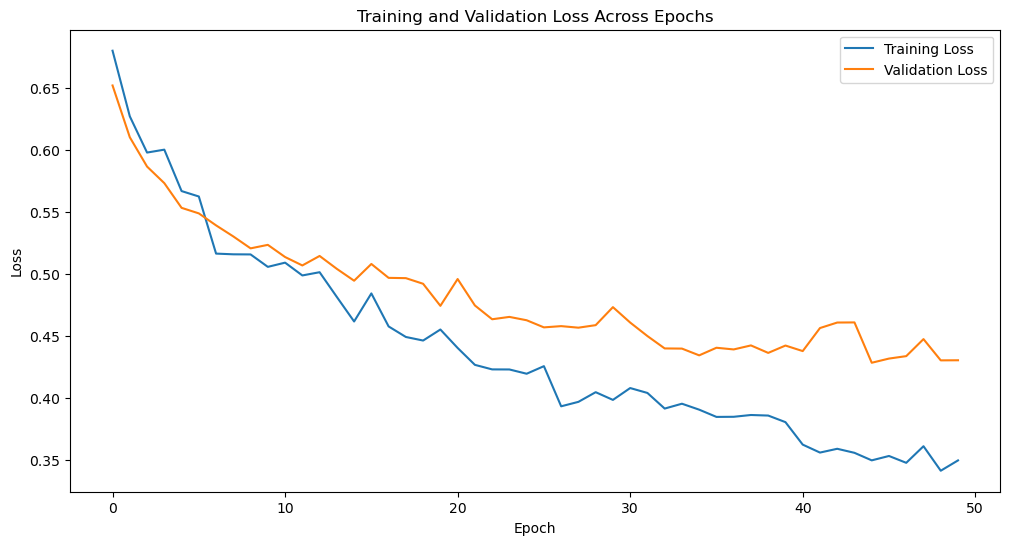

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Takeaways:
* The training loss continues to decrease almost reaching 0.35 indicating the mdoel is fitting better to the train data with each epoch
* The valdiation decreases as well about around 10-15 epochs it smoothesn out at 0.45

Given this graph we will need to implement early stopping, increase dropout, potential reduce layers, regularize, and use fewer epochs

## Neural Networks (v2)

Implemented the following:
* early stopping
* increased dropout
* regularization

In [111]:
# Initialize the neural network
model = Sequential()

# Input layer with 36 features as input_dim
model.add(Dense(128, input_dim=35, activation='relu'))

# Hidden layer with L1 regularization and reduced dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               4608      
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14977 (58.50 KB)
Trainable params: 1497

With this neural network we actually actually matches our accuracy that we were able to get in our Gradient Boost data that used the interaction features for heavy weighting. I think its probably worth  playing around with this a bit more.

## Neural Networks (v3)
Implemented
- No dropout
- Different L2 Strengths

Epoch 1/100
22/22 [==============================] - 1s 11ms/step - loss: 16.6102 - accuracy: 0.5845 - val_loss: 13.8594 - val_accuracy: 0.6517
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 11.8656 - accuracy: 0.6589 - val_loss: 9.8251 - val_accuracy: 0.6336
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 8.3932 - accuracy: 0.6574 - val_loss: 6.9423 - val_accuracy: 0.6426
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 5.9373 - accuracy: 0.6501 - val_loss: 4.9223 - val_accuracy: 0.6396
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 4.2246 - accuracy: 0.6531 - val_loss: 3.5243 - val_accuracy: 0.6306
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 3.0456 - accuracy: 0.6560 - val_loss: 2.5681 - val_accuracy: 0.6336
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 2.2444 - accuracy: 0.6385 - val_loss: 1.9240 - val_accuracy: 0.6216
Epoch 8/1

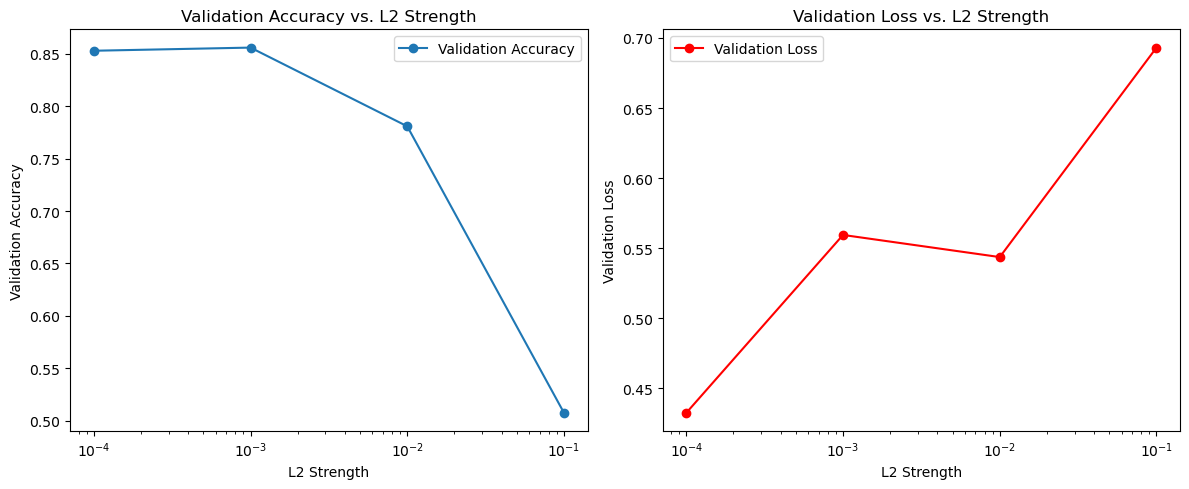

In [115]:
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# Assuming you have X_train, y_train, X_test, y_test defined somewhere above
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

l2_values = [1e-1, 1e-2, 1e-3, 1e-4]

# To store validation accuracy and loss for each L2 value
val_accuracies = []
val_losses = []

for l2_strength in l2_values:
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=35, kernel_regularizer=l2(l2_strength)))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])
    
    # Store the final validation accuracy and loss
    val_accuracies.append(history.history['val_accuracy'][-1])
    val_losses.append(history.history['val_loss'][-1])

# Visualizing the validation accuracy and loss for each L2 value
plt.figure(figsize=(12, 5))

# Plotting validation accuracy
plt.subplot(1, 2, 1)
plt.plot(l2_values, val_accuracies, marker='o', label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('L2 Strength')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. L2 Strength')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(l2_values, val_losses, marker='o', color='red', label='Validation Loss')
plt.xscale('log')
plt.xlabel('L2 Strength')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. L2 Strength')
plt.legend()

plt.tight_layout()
plt.show()


Takeaways:
* the smaller the stronger the L2 the worse validation accuracy gets meaning its leading to underfitting
* however, the validation loss is the lowest for the weak l2 strength, meaning strong L2 is only hurting us

Lets Examine the training metrics again to help lead us in what we want to modify in our model

Epoch 1/100
22/22 [==============================] - 0s 7ms/step - loss: 0.2696 - accuracy: 0.9082 - val_loss: 0.4272 - val_accuracy: 0.8438
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2557 - accuracy: 0.9111 - val_loss: 0.4564 - val_accuracy: 0.8318
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2527 - accuracy: 0.9023 - val_loss: 0.4524 - val_accuracy: 0.8348
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2450 - accuracy: 0.9140 - val_loss: 0.4752 - val_accuracy: 0.8529
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2576 - accuracy: 0.9111 - val_loss: 0.5746 - val_accuracy: 0.7988
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2945 - accuracy: 0.8950 - val_loss: 0.6196 - val_accuracy: 0.8078
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 0.2830 - accuracy: 0.9009 - val_loss: 0.4885 - val_accuracy: 0.8288
Epoch 8/100
2

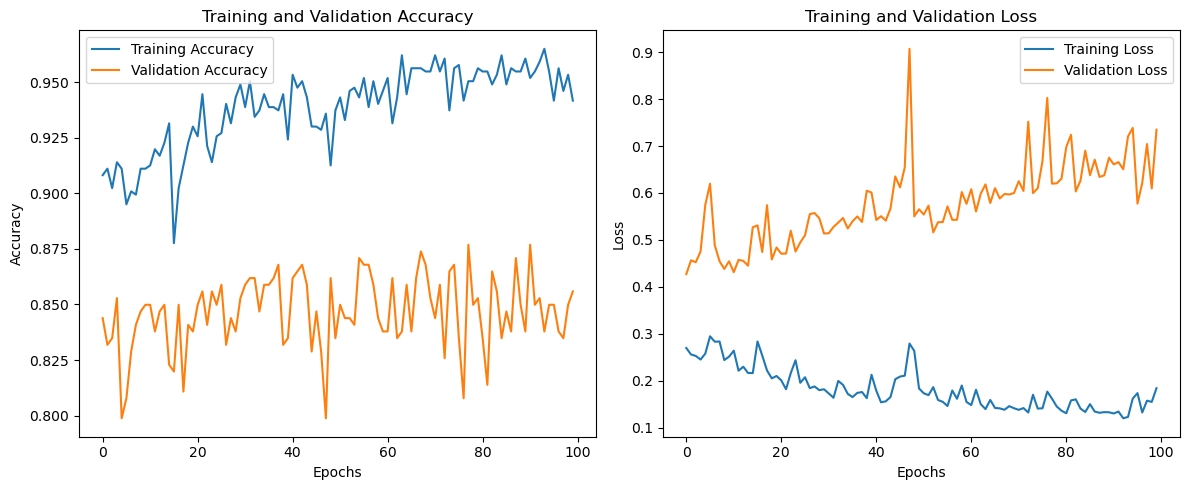

In [117]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Plot Training and Validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Neural Networks (v4)
Parameters:
* Learning rate: 1e-4
* L2 Regularization
* Dropout
* Early Stopping
* 5 Layers

In [132]:
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4), input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # assuming binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stop])


Epoch 1/100
22/22 [==============================] - 2s 28ms/step - loss: 0.6831 - accuracy: 0.5962 - precision: 0.6130 - recall: 0.5219 - val_loss: 0.6523 - val_accuracy: 0.6396 - val_precision: 0.8182 - val_recall: 0.3728
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 0.6245 - accuracy: 0.6880 - precision: 0.8177 - recall: 0.4840 - val_loss: 0.5843 - val_accuracy: 0.7177 - val_precision: 0.9310 - val_recall: 0.4793
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.5804 - accuracy: 0.7303 - precision: 0.8086 - recall: 0.6035 - val_loss: 0.5450 - val_accuracy: 0.7327 - val_precision: 0.9348 - val_recall: 0.5089
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 0.5432 - accuracy: 0.7391 - precision: 0.8203 - recall: 0.6122 - val_loss: 0.5249 - val_accuracy: 0.7748 - val_precision: 0.8917 - val_recall: 0.6331
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.5336 - accuracy: 0.7624 - precis

#### Biggest Takeaways:
* L2 Regularization is critical here
* Dropout was the largest influence towards model accuracay overall
* Additional complexity did make slight improvements to the model

## Bagging Model (v1)

In [146]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1,
    random_state=42
)

# Assuming X_train, y_train are your training data
bag_clf.fit(X_train, y_train)

# To get predictions: bag_clf.predict(X_test)
bag_clf.predict(X_test)

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,

In [147]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss

# Assuming you've already split your data into training and testing sets
# and you've already trained your bag_clf

# Get predictions on the test set
y_pred = bag_clf.predict(X_test)
y_pred_prob = bag_clf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Log Loss
logloss = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8498
Precision: 0.8647
Recall: 0.8448
F1 Score: 0.8547

ROC AUC Score: 0.9368
Log Loss: 0.3280

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       159
           1       0.86      0.84      0.85       174

    accuracy                           0.85       333
   macro avg       0.85      0.85      0.85       333
weighted avg       0.85      0.85      0.85       333

Confusion Matrix:
[[136  23]
 [ 27 147]]


### 1st Run Through Lessons

* Best Model:
    * XGBoost with a precision recall and accuray of 91%
* Feature Set:
    * Feature Interaction features and heavy weighting gives us more of the intended results of what it is we want to get from our models
    * Market Cap and Income are and should be the leading indicators of whether or not a stock is in the index
* Lessons:
    * We need more quarterly income data going back a bit further but probably not to before covid
    * I am fearful of how the model will perform once we add in the NLP data for market sentiment
    * neural networks may be too complex of a model for this dataset; XGBoost does the job well
* What to do next:
    * Use only the quarterly income feature set as I feel the volume data invites way too much noise

## Classification Model Prep (2nd Run Through)

We are going to run through all the models above with a new feature set. We are going to drop 12 months of volume column which despite it was time consuming and costly to get it is severely hurting our model here. So the feature set will be the same with the exception of 12 less monthyl volume columns

In [134]:
market = pd.concat([snp, rus], ignore_index=True)
market = market.sample(frac=1).reset_index(drop=True)

X = market.drop(columns=['in_index','Month1_Volume', 'Month2_Volume', 'Month3_Volume', 'Month4_Volume',
       'Month5_Volume', 'Month6_Volume', 'Month7_Volume', 'Month8_Volume',
       'Month9_Volume', 'Month10_Volume', 'Month11_Volume', 'Month12_Volume',
       'Month13_Volume', 'Month14_Volume', 'Month15_Volume', 'Month16_Volume',
       'Month17_Volume', 'Month18_Volume', 'Month19_Volume', 'Month20_Volume',
       'Month21_Volume', 'Month22_Volume', 'Month23_Volume', 'Month24_Volume'])
y = market['in_index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [135]:
# Saving Ticker for later identification
tickers_train = X_train['Ticker'].copy()
tickers_test = X_test['Ticker'].copy()

# Dropping Ticker and Exchange
X_train = X_train.drop(columns=['Ticker', 'Exchange'])
X_test = X_test.drop(columns=['Ticker', 'Exchange'])

In [136]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## BEST Logistic Regression Model

In [137]:
%timeit
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['saga', 'liblinear'],  # Only these solvers support l1
        'class_weight': [None, 'balanced'],
        'C': np.logspace(-4, 4, 10)
    },
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'sag', 'saga', 'newton-cg', 'liblinear'],
        'class_weight': [None, 'balanced'],
        'C': np.logspace(-4, 4, 10)
    }
]

grid = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42),
                    param_grid, cv=5, scoring='f1', n_jobs=-1)

grid.fit(X_train, y_train)

# Retrieve the best estimator
clf_best = grid.best_estimator_

# 3. Model Evaluation
# -------------------

# Predict on test set
y_pred = clf_best.predict(X_test)
y_pred_proba = clf_best.predict_proba(X_test)[:,1]

# Print performance metrics
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log Loss:", log_loss(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
play_sound()

ROC AUC Score: 0.8923949974698187
Log Loss: 0.4867872657267001
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.78       159
           1       0.85      0.68      0.76       174

    accuracy                           0.77       333
   macro avg       0.78      0.78      0.77       333
weighted avg       0.79      0.77      0.77       333

Confusion Matrix:
 [[138  21]
 [ 55 119]]


## BEST Random Forest Classifier

In [141]:
param_grid = {
    'n_estimators': [50,100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [ 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2', None]  # Added max_features
}

rf = RandomForestClassifier(random_state=42)

# Here we're going to use both KFold and StratifiedKFold for demonstration, you can choose one based on your data.
cv_methods = [KFold(n_splits=5, shuffle=True, random_state=42), 
              StratifiedKFold(n_splits=5, shuffle=True, random_state=42)]

best_scores = {}
best_params = {}

for cv_method in cv_methods:
    grid_search = GridSearchCV(rf, param_grid, cv=cv_method, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Predict on test set
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Save results for current cv_method
    method_name = str(cv_method).split("(")[0]  # Extracting the name of the CV method for display purposes
    best_scores[method_name] = roc_auc_score(y_test, y_pred_proba)
    best_params[method_name] = grid_search.best_params_

    # Print out metrics
    print(f"Cross-Validation Method: {method_name}")
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Log Loss:", log_loss(y_test, y_pred_proba))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Best Parameters:", grid_search.best_params_)
    print("==============================================\n")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Cross-Validation Method: KFold
ROC AUC Score: 0.9343237186438227
Log Loss: 0.42271138079059567
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       159
           1       0.88      0.85      0.86       174

    accuracy                           0.86       333
   macro avg       0.86      0.86      0.86       333
weighted avg       0.86      0.86      0.86       333

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Cross-Validation Method: StratifiedKFold
ROC AUC Score: 0.9376852454276007
Log Loss: 0.32446195653347865
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       159
           1       0.89      0.85      0.87       174

    ac

## BEST Gradient Boosting Tree

In [143]:
# Ensure you've defined your train/test split and the XGBClassifier
from xgboost import XGBClassifier

# Given the best parameters from before:
best_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8,
    'objective': 'binary:logistic'
}

xgbc = XGBClassifier(**best_params)
xgbc.fit(X_train, y_train)

# Now calibrate using CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgbc = CalibratedClassifierCV(xgbc, method='sigmoid', cv='prefit')
calibrated_xgbc.fit(X_train, y_train)
probs = calibrated_xgbc.predict_proba(X_test)

In [144]:
y_prob_calibrated = calibrated_xgbc.predict_proba(X_test)[:, 1]

# Convert probabilities to class predictions (threshold = 0.5)
y_pred_calibrated = (y_prob_calibrated > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_calibrated))

# Print the ROC AUC Score and Log Loss
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_calibrated))
print("Log Loss:", log_loss(y_test, y_prob_calibrated))


              precision    recall  f1-score   support

           0       0.83      0.86      0.84       159
           1       0.86      0.84      0.85       174

    accuracy                           0.85       333
   macro avg       0.85      0.85      0.85       333
weighted avg       0.85      0.85      0.85       333

ROC AUC Score: 0.9388418998048146
Log Loss: 0.3985782256258598


## Best Gradient Boosting Tree w/ Heavy Weighting

In [145]:
# Creating interaction features with other highly correlated features
market['MarketCap_Q8NetIncome'] = market['Market Cap'] * market['Q8_NetIncome']
market['MarketCap_Q7NetIncome'] = market['Market Cap'] * market['Q7_NetIncome']

# Duplicating the Market Cap feature to give it more weight
market['MarketCap_duplicate'] = market['Market Cap']

# Duplicating the Q1, Q2, Q3, Q4 incomes to give them more weight
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
for q in quarters:
    col_name = f'{q}_NetIncome'
    duplicate_col_name = f'{q}_NetIncome_duplicate'
    market[duplicate_col_name] = market[col_name]

# Splitting the data
X_special = market.drop(['in_index', 'Ticker', 'Exchange'], axis=1)
y_special = market['in_index']
X_train_special, X_test_special, y_train_special, y_test_special = train_test_split(X_special, y_special, test_size=0.3, random_state=42)

# Training the XGBoost model
xgbc = xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8)
xgbc.fit(X_train_special, y_train_special)

# Predictions and metrics
y_pred_special = xgbc.predict(X_test_special)
y_pred_proba_special = xgbc.predict_proba(X_test_special)[:, 1]

print(classification_report(y_test_special, y_pred_special))
print("ROC AUC Score:", roc_auc_score(y_test_special, y_pred_proba_special))
print("Log Loss:", log_loss(y_test_special, y_pred_proba_special))

# Drop the added columns from market
columns_to_drop = ['MarketCap_Q8NetIncome', 'MarketCap_Q7NetIncome', 'MarketCap_duplicate']
for q in quarters:
    duplicate_col_name = f'{q}_NetIncome_duplicate'
    columns_to_drop.append(duplicate_col_name)

market.drop(columns_to_drop, axis=1, inplace=True)


              precision    recall  f1-score   support

           0       0.83      0.88      0.85       145
           1       0.89      0.83      0.86       158

    accuracy                           0.85       303
   macro avg       0.86      0.86      0.85       303
weighted avg       0.86      0.85      0.85       303

ROC AUC Score: 0.9394151025752946
Log Loss: 0.3265426435796759


### 2nd Run Through Lessons:

* ALL my models performed significantly worse with the dropped data....

## What To Do Next:
* Collect NLP Data
* Run some Clustering, KNN Models, SVM

# Model 2: Predictive Model of Next Qaurterly Net Income

## Predictive Model Prep

In [17]:
np.random.seed(42)

In [18]:
market = pd.concat([snp, rus], ignore_index=True)
market = market.sample(frac=1).reset_index(drop=True)

column_mappings = {
    "Q1_NetIncome": "NetIncome_Sep_30_2023",
    "Q2_NetIncome": "NetIncome_Jun_30_2023",
    "Q3_NetIncome": "NetIncome_Mar_31_2023",
    "Q4_NetIncome": "NetIncome_Dec_31_2022",
    "Q5_NetIncome": "NetIncome_Sep_30_2022",
    "Q6_NetIncome": "NetIncome_Jun_30_2022",
    "Q7_NetIncome": "NetIncome_Mar_31_2022",
    "Q8_NetIncome": "NetIncome_Dec_31_2021"
}

market.rename(columns=column_mappings, inplace=True)
market["NetIncome_Dec_31_2023"] = np.nan

In [19]:
X = market.drop(columns=["NetIncome_Dec_31_2023"])
y = market["NetIncome_Dec_31_2023"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
# Saving Ticker for later identification
tickers_train = X_train['Ticker'].copy()
tickers_test = X_test['Ticker'].copy()

# Dropping Ticker and Exchange
X_train = X_train.drop(columns=['Ticker', 'Exchange'])
X_test = X_test.drop(columns=['Ticker', 'Exchange'])